# Load in Data

In [28]:
import json
from pathlib import Path
import pandas as pd
import ast
from collections import Counter
from tqdm import tqdm

In [7]:
import editdistance as ed
def find_match_word(rec_str, lexicon, pair):
    rec_str = rec_str.upper()
    match_word = ''
    match_dist = 100
    for word in lexicon: ## Find corresponding word in lexicon that has the smallest edit distance
        word = word.upper()
        ed_dist = ed.eval(rec_str, word)
        norm_ed_dist = ed_dist / max(len(word), len(rec_str))
        if norm_ed_dist < match_dist:
            match_dist = norm_ed_dist
            if pair:
                match_word = pair[word] ## Pair the word with its ground truth (may have special characters)
            else:
                match_word = word
    return match_word, match_dist

In [8]:
### official code
def include_in_dictionary(transcription):
    #special case 's at final
    if transcription[len(transcription)-2:]=="'s" or transcription[len(transcription)-2:]=="'S":
        transcription = transcription[0:len(transcription)-2]
    #hypens at init or final of the word
    transcription = transcription.strip('-');
    specialCharacters = str("'!?.:,*\"()·[]/"); # remove special characters
    for character in specialCharacters:
        transcription = transcription.replace(character,' ')
    transcription = transcription.strip()
    if len(transcription) != len(transcription.replace(" ","")) :
        return False;
    if len(transcription) < 3:
        return False;
    notAllowed = str("×÷·");
    range1 = [ ord(u'a'), ord(u'z') ]
    range2 = [ ord(u'A'), ord(u'Z') ]
    range3 = [ ord(u'À'), ord(u'ƿ') ]
    range4 = [ ord(u'Ǆ'), ord(u'ɿ') ]
    range5 = [ ord(u'Ά'), ord(u'Ͽ') ]
    range6 = [ ord(u'-'), ord(u'-') ]
    for char in transcription :
        charCode = ord(char)
        if(notAllowed.find(char) != -1):
            return False
        valid = ( charCode>=range1[0] and charCode<=range1[1] ) or ( charCode>=range2[0] and charCode<=range2[1] ) or ( charCode>=range3[0] and charCode<=range3[1] ) or ( charCode>=range4[0] and charCode<=range4[1] ) or ( charCode>=range5[0] and charCode<=range5[1] ) or ( charCode>=range6[0] and charCode<=range6[1] )
        if valid == False:
            return False
    return True

def include_in_dictionary_transcription(transcription):
    #special case 's at final
    if transcription[len(transcription)-2:]=="'s" or transcription[len(transcription)-2:]=="'S":
        transcription = transcription[0:len(transcription)-2]
    #hypens at init or final of the word
    transcription = transcription.strip('-');            
    specialCharacters = str("'!?.:,*\"()·[]/");
    for character in specialCharacters:
        transcription = transcription.replace(character,' ')
    transcription = transcription.strip()
    return transcription

In [9]:
def filter_transcription(rec):
    import numpy as np
    if include_in_dictionary(rec) == False: ## Check if the transcription is a valid word
        rec = np.nan
    else:
        rec = include_in_dictionary_transcription(rec) ## remove special characters
    return rec
    

In [10]:
import re
IS_WORDSPOTTING = True
def count_matches_per_row(row):
    # ignore_case_symbol
    valid_symbol =  '[^A-Z^a-z^0-9^\-^\']'  ##'[^A-Z^a-z^0-9^\u4e00-\u9fa5]'
    valid_symbol = re.compile(valid_symbol)
    
    # Remove Don't care symbol    
    left_side = pd.Series([valid_symbol.sub('', i.upper()) for i in row['text'].split(' ') if valid_symbol.sub('', i.upper())])
    right_side = pd.Series([valid_symbol.sub('', i.upper()) for i in row['rec_texts'] if valid_symbol.sub('', i.upper())])
    
    #On word spotting we will filter some transcriptions with special characters
    if IS_WORDSPOTTING:
        left_side = left_side.apply(filter_transcription)
        right_side = right_side.apply(filter_transcription)
        
                    
    counter_left = Counter(left_side.dropna()) # dic
    counter_right = Counter(right_side.dropna())
    
    # 计算两侧相同元素的个数，确保每个元素只计算一次
    matches = sum((counter_left & counter_right).values())
    total = sum(counter_left.values()) #numGTcare
    numDetCare = sum(counter_right.values()) #numDetCare
    matches = sum((counter_left & counter_right).values())
    total = sum(counter_left.values())
    total_char = sum([len(word)*freq for word,freq in counter_left.items()])
    match_char = sum([len(word)*freq for word,freq in (counter_left & counter_right).items()])
    numDetCare_char = sum([len(word)*freq for word,freq in counter_right.items()])
    
    return [total, matches, numDetCare, total_char, match_char,numDetCare_char]


In [11]:
filter_df = pd.read_csv('../../data/human/SelectedFilter.csv')

In [12]:
def matrix_cal(row):
    precision = 0 if float(row['match'])==0 else float(row['match']) / row['numDetCare']
    recall = 0 if float(row['match'])==0 else float(row['match']) / row['numGTcare']
    f1 = 0 if (precision + recall==0) else 2.0 * precision * recall / (precision + recall)
    
    precision_char = 0 if float(row['match_char'])==0 else float(row['match_char']) / row['numDetCare_char']
    recall_char = 0 if float(row['match_char'])==0 else float(row['match_char']) / row['numGTcare_char']
    f1_char = 0 if (precision_char + recall_char==0) else 2.0 * precision_char * recall_char / (precision_char + recall_char)
    return f1
    
    

In [36]:
FOLDER = 'totaltext'#'human/totaltext/converted' 'totaltext_all' 'totaltext'
output_dir = Path(f"../../filtered/{FOLDER}") if 'converted' not in FOLDER else Path(f"../../data/{FOLDER}") 
gt_dir = Path(f"../../data/{FOLDER}") if 'converted' not in FOLDER else Path(f"../../data/totaltext") 
files = list(output_dir.rglob('*.*'))
result_li = []
stratify_li = [] # Classify by acc in no-filter condition
ba_li = []
df_human = pd.read_csv('../../data/human/human_totaltext_acuity_251014.csv')
# Load the ground truth COCO JSON (annotations only or full dataset)
with open(gt_dir/"anno.json", "r") as f:
    ground_truth = json.load(f)
# Here we assume ground_truth has a key "annotations"
gt_annotations = ground_truth.get("annotations", [])
img_info = ground_truth.get("images", [])

for model_file in tqdm(files, total=len(files), desc="Rinse model outputs"):
    # Load the model output JSON (replace with your file or object)
    # model_file = output_dir/ "gpt4o.json"
    model_name = model_file.stem
    with open(model_file, "r") as f:
        model_output = json.load(f)

    # Create lookup dictionaries for ground truth annotations and image info by image_id.
    # If there are multiple ground truth annotations per image, you might need to store a list.
    gt_by_chart = {}
    for info, ann in zip(img_info, gt_annotations):
        id = ann["id"]
        full = {}
        full["image_id"] = ann["image_id"]
        full["file_name"] = info["file_name"]
        full["Filter_no"] = info["Filter_no"]
        full["text"] = ann["caption"]
        gt_by_chart.setdefault(id, full)
        
    
    # Now iterate through the model outputs and match with ground truth and image info
    full_out = {}
    for output_item in model_output:
        image_id = output_item["image_id"]
        
        # Optionally, if your model output's "rec_texts" is a string representation of a list,
        # convert it to an actual list.
        rec_texts_str = output_item.get("rec_texts", "")
        try:
            rec_texts = ast.literal_eval(rec_texts_str)
        except Exception:
            rec_texts = rec_texts_str
        output_item["rec_texts"] = rec_texts

        # Retrieve corresponding ground truth annotations (if any)
        gt_matches = gt_by_chart.get(image_id, {})
        chart_no = Path(gt_matches.get("file_name", "")).stem.split("/")[-1]
        full_out[image_id] = gt_matches
        full_out[image_id]["rec_texts"] = rec_texts
        full_out[image_id]["chart_no"] = chart_no

        
        
    df = pd.DataFrame(full_out.values())
    df = pd.merge(df, filter_df, on='Filter_no', how='inner')

    df[['numGTcare','match', 'numDetCare','numGTcare_char', 'match_char','numDetCare_char']] = df.apply(lambda row: count_matches_per_row(row), axis=1).apply(pd.Series)
    df[['f1']] = df.apply(lambda x: matrix_cal(x), axis=1).apply(pd.Series)
    
    # BA-test
    df_ba = pd.merge(df,df_human, on=['a', 'b', 'VA', 'CS', 'Cond'],how='left')
    results = []

    for cond, group in df_ba.groupby(['a', 'b', 'VA', 'CS', 'Cond']):
        diff = (group['f1'] - group['human'])
        avg = (group['f1'] + group['human'])/2
        bias = diff.mean()
        loa_low = bias - 1.96 * diff.std()
        loa_high = bias + 1.96 * diff.std()
        out_of_loa = (diff < loa_low) | (diff > loa_high)
        total = len(diff)
        out_of_loa_ratio = out_of_loa.sum()/total
            
        results.append({
                'Expected': cond[2], # VA
                'Cond': cond[4],
                'Model': model_name,
                'Bias': bias,
                'Diff': diff,
                'Avg': avg,
                'LoA_Low': loa_low,
                'LoA_High': loa_high,
                'Out_of_LOA_ratio': out_of_loa_ratio,
                'Out_of_LOA': out_of_loa.sum()
            })
    ba_li.append(pd.DataFrame(results))

    

    group_sum = df.copy()
    # group_sum.columns = ['chart_no', 'a', 'b', 'VA', 'CS', 'Cond','f1']
    group_sum = group_sum.groupby(['a', 'b', 'VA', 'CS', 'Cond']).apply(lambda x: x['f1'].mean()).reset_index()
    group_sum.columns = ['a', 'b', 'VA', 'CS', 'Cond',model_name]
    result_li.append(group_sum)

    #stratify
    threshold = (0.5, 0.75) #quantile([0.5, 0.7])
    stratify_df = df.copy()
    stratify_df['Stratify'] = 'Low'
    for thr in threshold:
        stratify_df.loc[stratify_df['chart_no'].isin(stratify_df.loc[(stratify_df['Cond']=='Original') & (stratify_df['f1']>thr), 'chart_no']), 'Stratify'] = 'Medium' if thr==0.88 else 'High'
    # stratify_df = stratify_df.groupby(['a', 'b', 'VA', 'CS', 'Cond','Stratify']).apply(lambda x: x['f1'].mean()).reset_index()
    stratify_df = stratify_df[['chart_no','a', 'b', 'VA', 'CS', 'Cond','Stratify','f1']]
    stratify_df['Model'] = model_name
    stratify_df.columns = ['chart_no','a', 'b', 'VA', 'CS', 'Cond','Stratify','f1','Model']
    stratify_li.append(stratify_df)


Rinse model outputs:   0%|          | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_1731861/4249239520.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_sum = group_sum.groupby(['a', 'b', 'VA', 'CS', 'Cond']).apply(lambda x: x['f1'].mean()).reset_index()
Rinse model outputs:   4%|▍         | 1/26 [00:00<00:05,  4.43it/s]/tmp/ipykernel_1731861/4249239520.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gr

In [38]:
import numpy as np
import pandas as pd

# 1) 汇总所有模型、所有图片的逐图像 F1
all_perf = pd.concat(stratify_li, ignore_index=True)  # 列：chart_no,a,b,VA,CS,Cond,f1,Model

# 2) 仅用 'Original' 条件来“定义图片分层”，确保每张图在所有模型都有 F1（去 NaN）
base = all_perf.loc[all_perf['Cond'] == 'Original'].copy()

# 2.1 pivot 成 每图像 × 每模型 的 F1 表
pivot = base.pivot_table(index=['chart_no','a','b','VA','CS','Cond'],
                         columns='Model', values='f1', aggfunc='mean')

# 2.2 只保留“所有模型都有值”的图像（避免缺模型的 NaN）
pivot = pivot.dropna(how='any')
model_cols = pivot.columns.tolist()

# 2.3 依据所有模型的 F1 给图片分层
high_mask = pivot[model_cols].gt(0.9).all(axis=1)   # 所有模型 F1>0.9
low_mask  = pivot[model_cols].lt(0.5).all(axis=1)   # 所有模型 F1<0.5
stratum = np.where(high_mask, 'High', np.where(low_mask, 'Low', 'Medium'))

pivot = pivot.reset_index()
pivot['Stratify'] = stratum

# ——（可选）拿到三类图片清单，后续可复用 —— 
high_charts = set(pivot.loc[pivot['Stratify']=='High',   'chart_no'])
low_charts  = set(pivot.loc[pivot['Stratify']=='Low',    'chart_no'])
mid_charts  = set(pivot.loc[pivot['Stratify']=='Medium', 'chart_no'])

# 3) 把图片分层映射回“所有条件”的逐图像行（和你原逻辑一致：以 Original 定义集合，再用于所有 Cond）
chart2stratum = pivot.set_index('chart_no')['Stratify']
all_perf['Stratify'] = all_perf['chart_no'].map(chart2stratum)
# 只保留被分层过的图片（即所有模型都有 Original 成绩）
all_perf = all_perf[all_perf['Stratify'].notna()].copy()

# 4) 计算“现在 stratify 用的那些值”：按 (a,b,VA,CS,Cond,Stratify,Model) 的平均 F1
strat = (all_perf
         .groupby(['a','b','VA','CS','Cond','Stratify','Model'])['f1']
         .mean()
         .reset_index())

# 5) 如果需要跟你之前的 wide 形状一致（各模型为列）：
df_stratify = (strat
              .pivot_table(index=['a','b','VA','CS','Cond','Stratify'],
                           columns='Model', values='f1')
              .reset_index())

# 6) 如果你仍然想把它加入你之前的 stratify_li 列表：
# stratify_li.append(strat_wide)

# —— 打印一下三类图片数量（可选）——
print(f"High charts (all models F1>0.75): {len(high_charts)}")
print(f"Low charts  (all models F1<0.5): {len(low_charts)}")
print(f"Medium charts (others):          {len(mid_charts)}")

High charts (all models F1>0.75): 11
Low charts  (all models F1<0.5): 4
Medium charts (others):          45


In [ ]:
tmp = df.loc[df['Cond']=='Original'].copy()
tmp['text_num'] = tmp['text'].apply(lambda x: len(x.split(' ')))
tmp['f1'] = tmp['f1'].round(2)
tmp.loc[tmp['f1']==1,['file_name','f1','text_num']].sort_values('text_num', ascending=False)

In [ ]:
tmp['text_num'].value_counts().sort_index()

In [ ]:
tmp['f1'].value_counts()

In [24]:
# for human
from functools import reduce
import numpy as np
summary_dir = Path("../../data/summary")
tmp_human = reduce(lambda left, right: pd.merge(left, right, on=['a', 'b', 'VA', 'CS', 'Cond'], how='outer'), result_li).fillna(0)
group_cols = ['a', 'b', 'VA', 'CS', 'Cond']

# 找出所有 Sub 列
sub_cols = [c for c in tmp_human.columns if c.startswith('Sub')]

def agg_subs(g):
    # 把所有 Sub 列合并成一列
    vals = g[sub_cols].to_numpy().ravel()
    vals = vals[~np.isnan(vals)]  # 去掉缺失值
    return pd.Series({
        'human': np.mean(vals),
        'human_std': np.std(vals, ddof=1)  # ddof=1 是样本标准差
    })

result = tmp_human.groupby(group_cols).apply(agg_subs).reset_index()

from functools import reduce
summary_dir = Path("../../data/human")
result.to_csv(summary_dir/'human_totaltext_acuity_251021.csv', index=False)

/tmp/ipykernel_809828/1103503072.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = tmp_human.groupby(group_cols).apply(agg_subs).reset_index()


In [61]:
from functools import reduce
summary_dir = Path("../../data/summary")
reduce(lambda left, right: pd.merge(left, right, on=['a', 'b', 'VA', 'CS', 'Cond'],how='outer'), result_li).to_csv(summary_dir/'totaltext_251014.csv', index=False)

In [ ]:
df_stratify = reduce(lambda left, right: pd.merge(left, right, on=['a', 'b', 'VA', 'CS', 'Cond','Stratify']), stratify_li)
df_stratify.to_csv(summary_dir/'totaltext_all_stratify.csv', index=False)

In [14]:
import pandas as pd
from functools import reduce
summary_dir = Path("../../data/summary")
df1 = reduce(lambda left, right: pd.merge(left, right, on=['a', 'b', 'VA', 'CS', 'Cond'],how='outer'), result_li).fillna(0)
df2 = pd.read_csv(summary_dir/'ScenetTextSummary.csv')
df2 = df2.pivot(index=['Filter_no','a','b','Cond','Expected_Change'], columns='Model')['f1'].reset_index()
df2.columns = [''.join(map(str, col)).strip() for col in df2.columns.values]
df2['Expected_Change'] = df2['Expected_Change'] - 0.24
df2.rename(columns={'Expected_Change':'Expected'}, inplace=True)
df2.drop(columns=['gpt4o','Cond','spts','cogvlm'], inplace=True)

df_human = pd.read_csv('../../data/human/human_totaltext_acuity_251021.csv')

In [17]:
final_df = pd.merge(pd.merge(df1, df_human, on=['a', 'b', 'VA', 'CS', 'Cond'],how='left'), df2, on=['a', 'b'], how='left')
# models = ['human', 'human_err', 'SeeingAI','gpt4o', 'gpt4o_mini', 'gemini_15_flash',
#        'gemini_15_pro', 'gemini_2_flash', 'claude3_7_sonnet', 'claude3_5_haiku',
#        'cogvlm','Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct',
    #    'db_maerecB', 'db_maerecS', 'dbpp_maerecB', 'dbpp_maerecS','spts', 'google']
# models = ['human', 'human_std', 'Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct','gemini-1.5-flash']
# final_df = pd.merge(pd.merge(df1, df_human, on=['a', 'b', 'VA', 'CS', 'Cond'],how='left'), df2, on=['a', 'b'], how='left')
models = ['human', 'human_std', 'Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct',
          'gpt-4o-mini', 'gpt-4o', 'gpt-5', 'gpt-5-mini', 
          'gemini-2.0-flash', 'gemini-2.5-flash', 'gemini-2.5-pro', 'claude-3-7-sonnet', 'claude-3-5-haiku', 'google_vision','maerec','spts','cogvlm','seeingai',
            'DeepSeek-OCR_Tiny', 'DeepSeek-OCR_Small', 'DeepSeek-OCR_Base', 'DeepSeek-OCR_Large','DeepSeek-OCR_Gundam', 
            'Qwen2.5-VL-3B-Instruct_text_desc', 'Qwen2.5-VL-7B-Instruct_text_desc', 'Qwen2.5-VL-32B-Instruct_text_desc',
            'gemini-2.5-flash_text_desc'
       ]
final_df = final_df[['a', 'b', 'VA', 'CS', 'Cond', 'Expected'] + models]
final_df.to_csv(summary_dir/'totaltext_combined_251007.csv', index=False)

# Figure

In [38]:
import pandas as pd

final_df_fig = pd.read_csv('../../data/summary/totaltext_combined_251007.csv')#final_df.copy()
# models = ['human','SeeingAI', 'gpt4o',
#        'gpt4o_mini', 'gemini_15_flash', 'gemini_15_pro', 'gemini_2_flash',
#        'claude3_7_sonnet', 'claude3_5_haiku', 'cogvlm',
#        'Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct',
#        'Qwen2.5-VL-32B-Instruct', 'dbpp_maerecB', 'spts', 'google'] #'db_maerecB', 'db_maerecS','dbpp_maerecS',

# models = ['human','Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct','gemini-1.5-flash']
# final_df_fig = final_df.copy() #pd.read_csv('../../data/summary/totaltext_combined_251007.csv') #final_df.copy()
final_df_fig[['Expected']] =  final_df_fig[['Expected']]  - final_df_fig.loc[15,['Expected']]
final_df_fig.loc[final_df_fig['Cond']=='Original', 'Cond'] = 'Combined'
models = ['human', 'human_std', 'Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct',
          'gpt-4o-mini', 'gpt-4o', 'gpt-5', 'gpt-5-mini', 
          'gemini-2.0-flash', 'gemini-2.5-flash', 'gemini-2.5-pro', 'claude-3-7-sonnet', 'claude-3-5-haiku', 'google_vision','maerec','spts','cogvlm','seeingai',
            'DeepSeek-OCR_Tiny', 'DeepSeek-OCR_Small', 'DeepSeek-OCR_Base', 'DeepSeek-OCR_Large','DeepSeek-OCR_Gundam', 
            # 'Qwen2.5-VL-3B-Instruct_text_desc', 'Qwen2.5-VL-7B-Instruct_text_desc', 'Qwen2.5-VL-32B-Instruct_text_desc',
            # 'gemini-2.5-flash_text_desc'
       ]
       
model_name_dict = {'human':'Human','SeeingAI':'SeeingAI', 'gpt4o':'GPT4O', 'gpt4o_mini':'GPT4O Mini', 'gpt-4o-mini':'GPT4o Mini', 'gpt-4o':'GPT4o', 'gpt-5-mini':'GPT5 Mini', 'gpt-5':'GPT5',
                   'gemini_15_flash':'Gemini-1.5 Flash','gemini_15_pro':'Gemini-1.5 Pro', 'gemini_2_flash':'Gemini-2 Flash', 'gemini-2.0-flash':'Gemini-2.0 Flash',
                   'gemini-1.5-pro':'Gemini-1.5 Pro', 'gemini-1.5-flash':'Gemini-1.5 Flash', 'gemini-2.5-pro':'Gemini-2.5 Pro', 'gemini-2.5-flash':'Gemini-2.5 Flash',
                   'claude3_7_sonnet':'Claude3.7 Sonnet', 'claude3_5_haiku':'Claude3.5 Haiku','cogvlm':'CogAgent',
                   'claude-3-7-sonnet':'Claude3.7 Sonnet', 'claude-3-5-haiku':'Claude3.5 Haiku', 'maerec':'DBNet++ & MaeRec',
                   'Qwen2.5-VL-3B-Instruct':'Qwen2.5-VL-3B', 'Qwen2.5-VL-7B-Instruct':'Qwen2.5-VL-7B', 'Qwen2.5-VL-32B-Instruct':'Qwen2.5-VL-32B',
                   'db_maerecB':'DBNet & MAERec-B', 'db_maerecS':'DBNet & MAERec-S', 'dbpp_maerecB':'DBNet++ & MaeRec-B','dbpp_maerecS':'DBNet++ & MaeRec-S',
                   'spts':'SPTS v2', 'ppocr':'PPOCR', 'azure':'Azure', 'gemini-1.5-flash':'Gemini-1.5 Flash', 'google_vision':'Google Vision', 'seeingai':'SeeingAI',
                   'DeepSeek-OCR_Tiny':'DeepSeek-OCR Tiny', 'DeepSeek-OCR_Small':'DeepSeek-OCR Small', 'DeepSeek-OCR_Base':'DeepSeek-OCR Base', 'DeepSeek-OCR_Large':'DeepSeek-OCR Large', 'DeepSeek-OCR_Gundam':'DeepSeek-OCR Gundam',
                   'Qwen2.5-VL-3B-Instruct_text_desc':'Qwen2.5-VL-3B-Instruct (Text)', 'Qwen2.5-VL-7B-Instruct_text_desc':'Qwen2.5-VL-7B-Instruct (Text)', 'Qwen2.5-VL-32B-Instruct_text_desc':'Qwen2.5-VL-32B-Instruct (Text)',
                   'gemini-2.5-flash_text_desc':'Gemini-2.5 Flash (Text)'
                   }
final_df_fig.rename(columns=model_name_dict, inplace=True)

models = [model_name_dict[i] for i in models if i in model_name_dict]

In [29]:
all_perf = pd.concat(stratify_li, ignore_index=True)  # 列：chart_no,a,b,VA,CS,Cond,f1,Model

all_perf = pd.merge(all_perf.pivot_table(index=['chart_no','a','b','VA','CS','Cond'],
                         columns='Model', values='f1', aggfunc='mean').reset_index().fillna(0), df_human, on=['a', 'b', 'VA', 'CS', 'Cond'],how='left')
all_perf.rename(columns=model_name_dict, inplace=True)

In [25]:
final_df_fig.loc[15, 'Cond'] = 'Original'
final_df_fig.groupby('Cond').mean().round(3).T

Cond,Combined,Horizontal,Original,Vertical
a,0.121,0.097,1.0,1.0
b,0.121,1.0,1.0,0.104
VA,0.966,0.966,-0.24,-0.034
CS,1.08,1.804,2.13,0.828
Expected,1.206,1.206,0.0,0.206
Human,0.486,0.552,0.934,0.632
human_std,0.165,0.21,0.093,0.221
Qwen2.5-VL-3B,0.384,0.485,0.915,0.673
Qwen2.5-VL-7B,0.39,0.502,0.935,0.693
Qwen2.5-VL-32B,0.404,0.515,0.953,0.74


In [32]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import pandas as pd

results = []

models = [c for c in all_perf.columns if c not in ['chart_no','a','b','VA','CS','Cond','Expected','Human','human_std','image_id']]

def add_sig_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

for cond, group in all_perf.groupby("Cond"):
    human = group["Human"]

    # 先对该 Cond 下所有模型计算原始 t 和 p
    tvals, pvals, names = [], [], []
    for model in models:
        t, p = ttest_ind(human, group[model], equal_var=False, nan_policy='omit')
        tvals.append(t)
        pvals.append(p)
        names.append(model)

    # Holm–Bonferroni 校正（控制 FWER）
    # rej 为在 alpha=0.05 下是否拒绝原假设的布尔数组
    rej, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method='holm')

    # 写回结果（用校正后的 p 打星）
    for model, t, p_raw, p_adj, r in zip(names, tvals, pvals, pvals_adj, rej):
        results.append({
            "Cond": cond,
            "Model": model,
            "t": t,
            "p_raw": p_raw,
            "p_adj_holm": p_adj,
            "reject_0.05": bool(r),
            "significant": add_sig_stars(p_adj)  # 用校正后的 p 值标星
        })

pd.DataFrame(results).to_csv('../../data/summary/totaltext_significance_251007.csv', index=False)

/cis/home/qgao14/my_documents/VIOCR_infer_models/py39/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
sns.set_theme(style="white")
# Define a function to choose marker based on condition
def get_marker(cond):
    if cond == 'Horizontal':
        return 'o'  # hollow square
    elif cond == 'Vertical':
        return '^'  # hollow triangle
    else:
        return 's'  # hollow circle

# Create a color palette for unique conditions
unique_conditions = final_df_fig['Cond'].unique()
# palette = sns.color_palette("viridis", len(unique_conditions))
# color_mapping = {cond: palette[i] for i, cond in enumerate(unique_conditions)}
colors = ['orange', 'black', '#6A9C89', 'black']
# Create the mapping
color_mapping = {cond: color for cond, color in zip(unique_conditions, colors)}

# Define a function to plot a scatter plot on a given axis for a specified model column
def plot_scatter(ax, model_col, df):
    # Plot each group (by Cond) separately to assign markers and colors
    for cond, group in df.groupby('Cond'):
        marker = get_marker(cond)
        ax.scatter(
            group['Expected'],
            group[model_col],
            label=cond,
            marker=marker,
            facecolors=color_mapping[cond],  # makes marker hollow
            edgecolors=color_mapping[cond],
            s=100  # marker size
        )
        # if model_col == 'human':
        #     ax.fill_between(pd.to_numeric(group['Expected'], errors='coerce'), 
        #                     pd.to_numeric(group[model_col], errors='coerce') - group['human_err'], 
        #                     pd.to_numeric(group[model_col], errors='coerce') + group['human_err'], 
        #                     color='red', alpha=0.05)
    
    # Add a dashed diagonal line that spans the range of the data
    # x_vals = df['Expected']
    # y_vals = df[model_col]
    # overall_min = min(x_vals.min(), y_vals.min())
    # overall_max = max(x_vals.max(), y_vals.max())
    # ax.plot([overall_min, overall_max], [overall_min, overall_max],
    #         linestyle='--', color='grey')
    
    # Set labels, title and legend
    ax.set_xlabel("Expected Acuity Change (logMAR)")
    ax.set_ylabel("F1 Score")
    ax.set_xticks(np.arange(0, 2.1, 0.5))
    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.set_title(f"{model_col}")
    # ax.tick_params(axis='both', labelsize=12)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    # ax.legend()

# List of models to plot (include 'human' and other models)
# models = ['human','SeeingAI' ,'gpt4o', 'gpt4o_mini', 'gemini_15_flash',
#        'gemini_15_pro', 'gemini_2_flash', 'claude3_7_sonnet', 'claude3_5_haiku',
#        'qwen', 'maerec','spts', 'ppocr', 'azure', 'google']

# Determine subplot grid layout; here we choose 2 columns
num_models = len(set(list(models) + ['Human']))
ncols = 5
nrows = math.ceil(num_models / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(3. * ncols, 3 * nrows))
# If there's only one subplot, axes is not an array; make it a list for consistency.
if num_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each model in its corresponding subplot
for i, model in enumerate(['Human'] + list(models)):
    plot_scatter(axes[i], model, final_df_fig)

# Remove any extra subplots if the grid has more axes than models
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])



handles, labels = axes.flatten()[0].get_legend_handles_labels()

# Place a common legend outside the figure. Here, loc='upper center' puts it at the top,
# and bbox_to_anchor adjusts its position. Adjust ncol for number of columns in legend.
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14)
plt.tight_layout()

plt.savefig('../../figure/totaltext_all_models.pdf', dpi=300)

## BA

In [ ]:
# def make_long_ba_df(ba_df_wide):
#     records = []
#     for _, row in ba_df_wide.iterrows():
#         diff = np.asarray(row["Diff"]).ravel()
#         avg  = np.asarray(row["Avg"]).ravel()
#         L = min(len(diff), len(avg))
#         if L == 0:
#             continue
#         # 逐样本展开
#         rec = pd.DataFrame({
#             "Model":    row["Model"],
#             "Cond":     row["Cond"],
#             "Expected_logMAR": row["Expected_logMAR"],
#             "Expected": avg[:L].astype(float),
#             "Bias":     diff[:L].astype(float),
#         })
#         records.append(rec)

#     long_df = pd.concat(records, ignore_index=True).dropna(subset=["Expected","Bias"])

#     # 每 (Model, Cond) 计算 BA 统计并回填
#     stats = (
#         long_df.groupby(["Model","Cond","Expected_logMAR"])["Bias"]
#         .agg(n="size", mean="mean", std=lambda s: np.nanstd(s, ddof=1))
#         .reset_index()
#         .rename(columns={"mean":"mean_bias","std":"std_bias"})
#     )
#     stats["LoA_Low"]  = stats["mean_bias"] - 1.96 * stats["std_bias"]
#     stats["LoA_High"] = stats["mean_bias"] + 1.96 * stats["std_bias"]
#     stats["LoA_Width"] = stats["LoA_High"] - stats["LoA_Low"]
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
def make_long_ba_df(ba_df_wide):
    records = []
    for i, row in ba_df_wide.iterrows():
        diff = np.asarray(row["Diff"]).ravel()
        avg  = np.asarray(row["Avg"]).ravel()
        L = min(len(diff), len(avg))
        if L == 0:
            continue
        mean_avg = avg.mean().astype(float)
        mean_diff = diff.mean().astype(float)
        # 逐样本展开
        rec = pd.DataFrame(data={
            "Model":    row["Model"],
            "Cond":     row["Cond"],
            "Expected_logMAR": row["Expected_logMAR"],
            "Expected": mean_avg,
            "Bias":     mean_diff,
            "LoA_Low":  mean_diff - 1.96 * np.std(diff, ddof=1),
            "LoA_High": mean_diff + 1.96 * np.std(diff, ddof=1),
            "LoA_Width": 2 * 1.96 * np.std(diff, ddof=1),
            "Out_of_LOA": row['Out_of_LOA'],
            "Out_of_LOA_ratio": row['Out_of_LOA_ratio'],
            "total": len(diff)
        },index=[i])
        records.append(rec)

    long_df = pd.concat(records, ignore_index=True).dropna(subset=["Expected","Bias"])

    # 每 (Model, Cond) 计算 BA 统计并回填
    # stats = (
    #     long_df.groupby(["Model","Cond","Expected_logMAR"])["Bias"]
    #     .agg(n="size", mean="mean", std=lambda s: np.nanstd(s, ddof=1))
    #     .reset_index()
    #     .rename(columns={"mean":"mean_bias","std":"std_bias"})
    # )
    # stats["LoA_Low"]  = stats["mean_bias"] - 1.96 * stats["std_bias"]
    # stats["LoA_High"] = stats["mean_bias"] + 1.96 * stats["std_bias"]
    # stats["LoA_Width"] = stats["LoA_High"] - stats["LoA_Low"]
    # out = long_df.merge(stats[["Model","Cond","Expected_logMAR","LoA_Low","LoA_High","LoA_Width"]], on=["Model","Cond","Expected_logMAR"], how="left")
    return long_df
ba_df = pd.concat(ba_li, axis=0)
ba_df['Expected'] = ba_df['Expected'] - (-0.24)
ba_df['Expected_logMAR'] = ba_df['Expected'] -0.24
ba_df.drop(columns=['Expected'], inplace=True)
ba_df["LoA_Width"] = ba_df["LoA_High"] - ba_df["LoA_Low"]
ba_df['Model'] = ba_df['Model'].map(model_name_dict).fillna(ba_df['Model'])
ba_df = pd.merge(ba_df.groupby(['Model','Cond','Expected_logMAR','Out_of_LOA','Out_of_LOA_ratio'])['Diff'].apply(lambda x: np.concatenate(x.dropna().values,axis=0)).reset_index(), 
ba_df.groupby(['Model','Cond','Expected_logMAR','Out_of_LOA','Out_of_LOA_ratio'])['Avg'].apply(lambda x: np.concatenate(x.dropna().values,axis=0)).reset_index(), on=['Model','Cond','Expected_logMAR','Out_of_LOA','Out_of_LOA_ratio'])
# ========= 展开并计算 LoA =========
ba_df = make_long_ba_df(ba_df)   # 注意：这里覆盖变量名，后续绘图直接用 ba_df


/cis/home/qgao14/my_documents/VIOCR_infer_models/py39/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cis/home/qgao14/my_documents/VIOCR_infer_models/py39/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


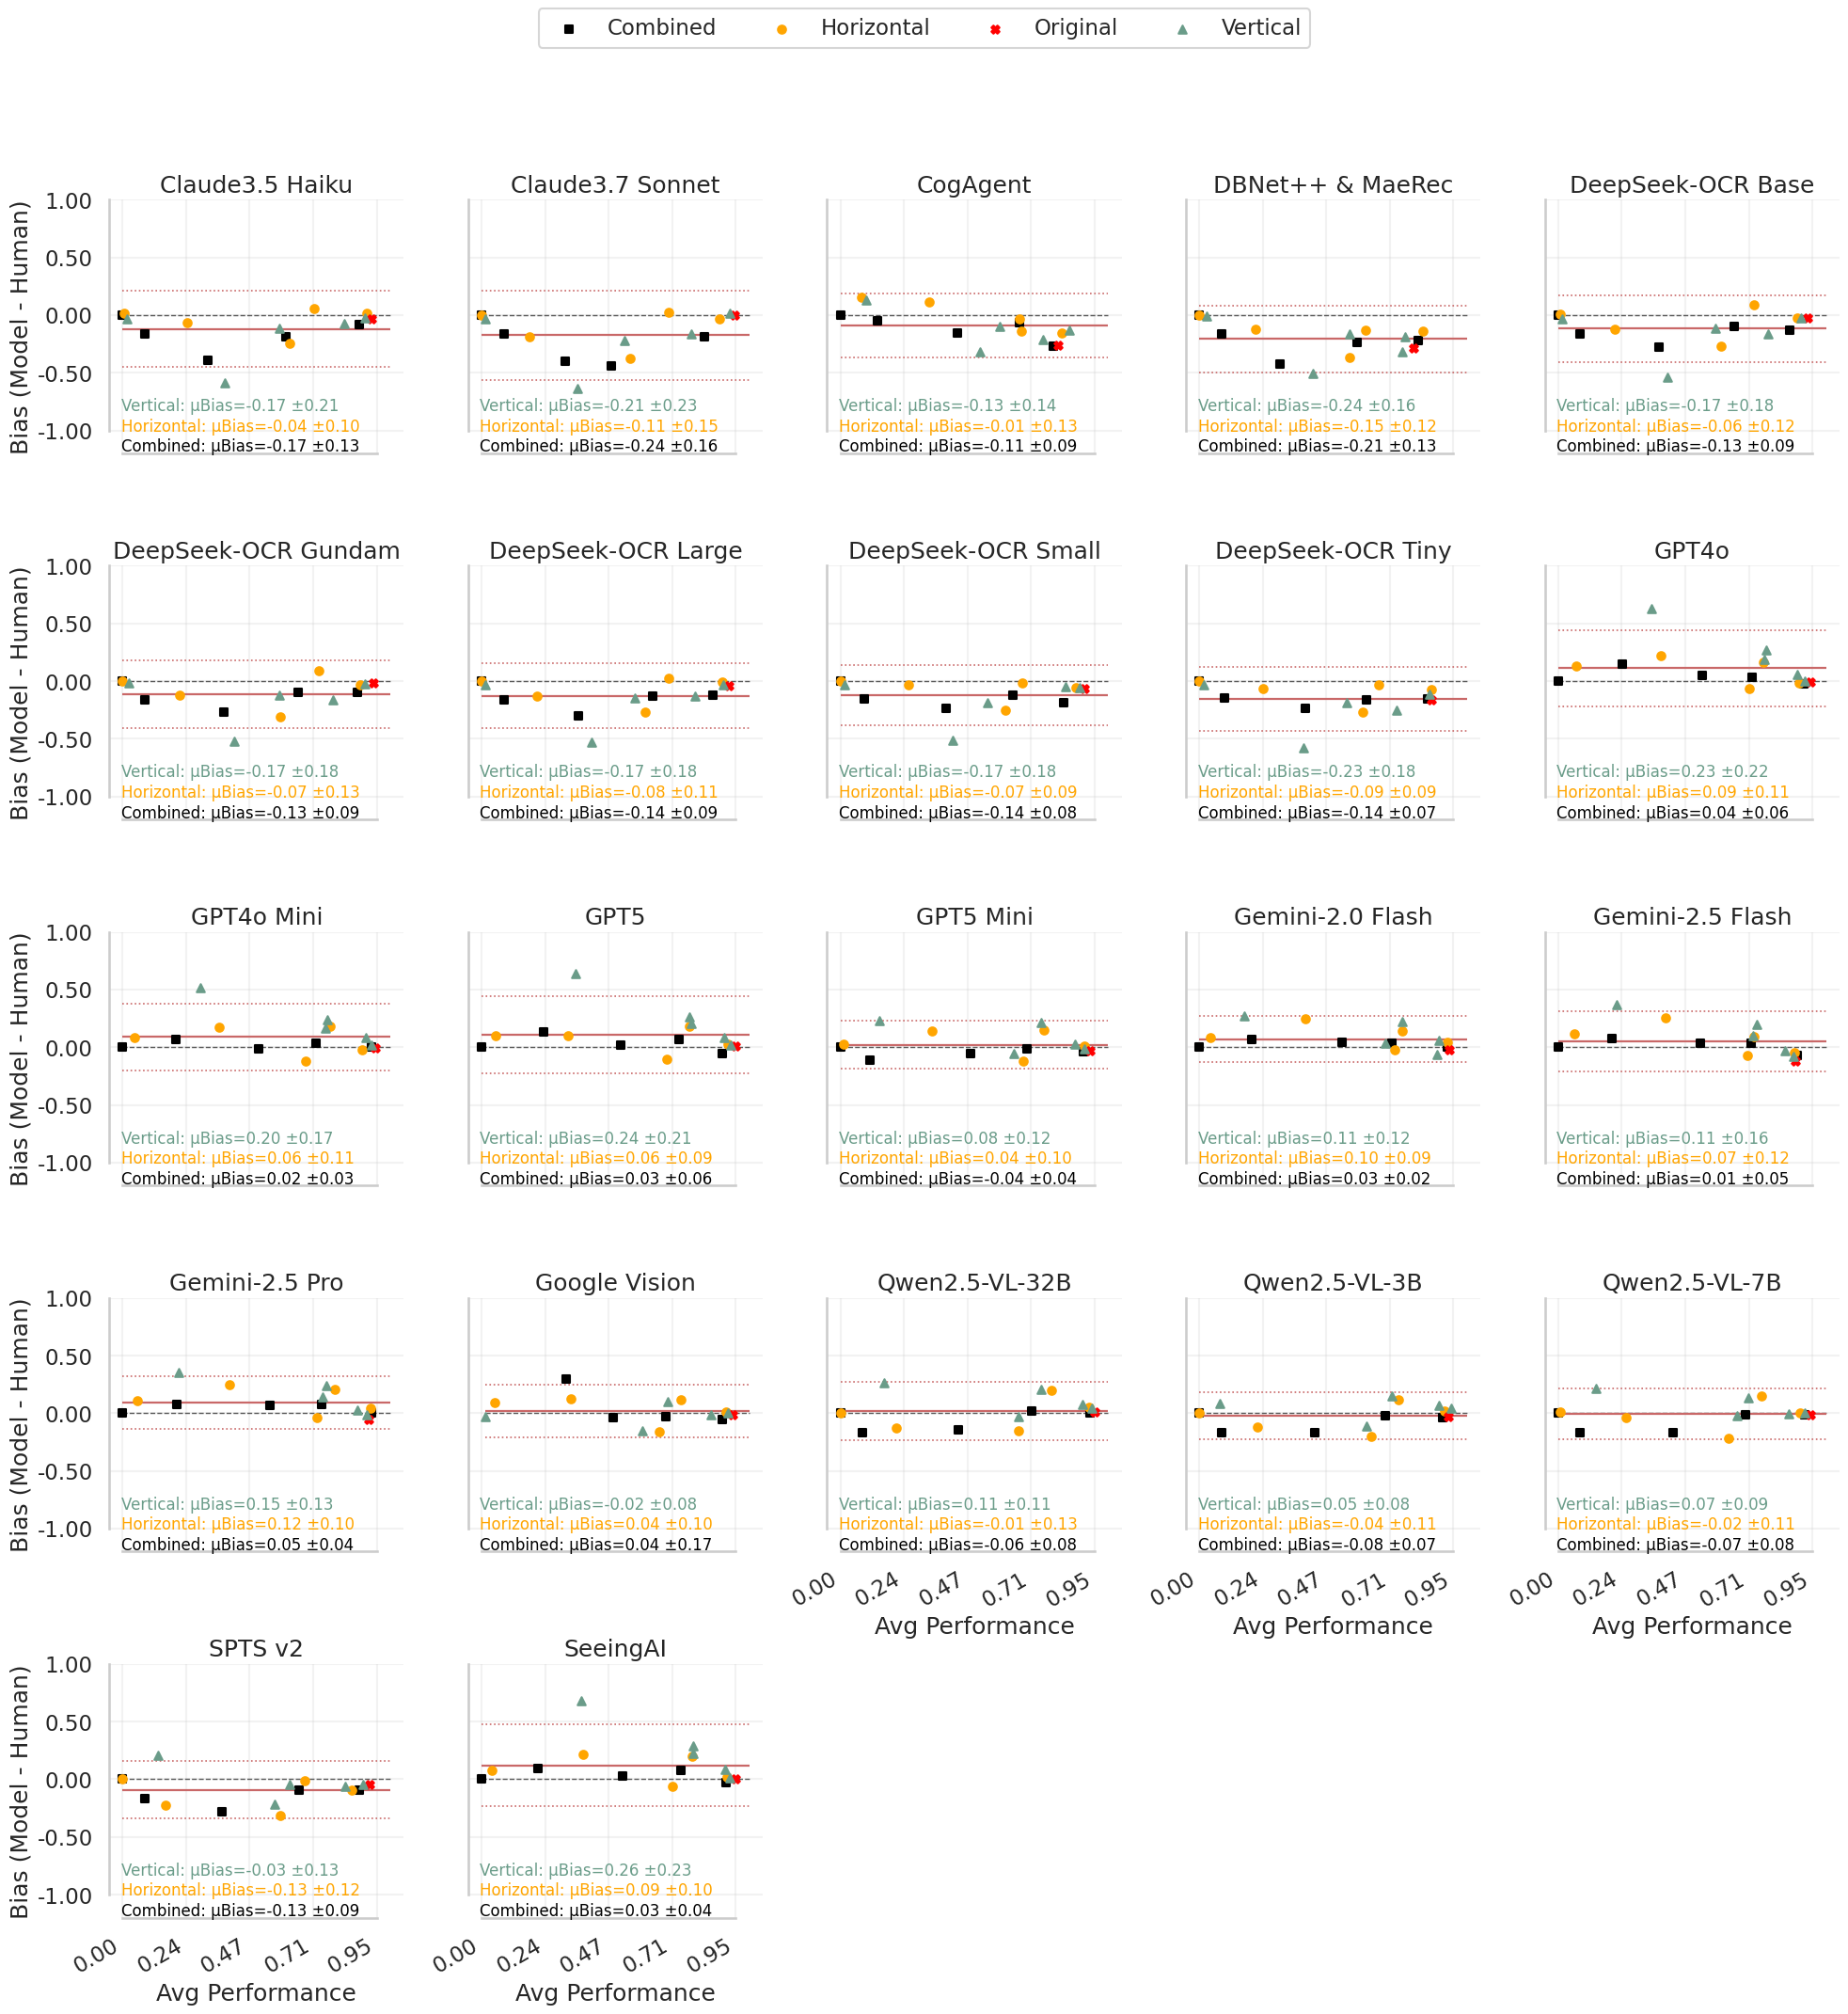

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# =====================================================
# 0) 将你的 ba_df(含 list) 展开为逐样本，同时计算 LoA
#     输入列:  Model, Cond, Diff(list), Avg(list)
#     输出列:  Model, Cond, Expected, Bias, LoA_Low, LoA_High, LoA_Width
# =====================================================




# =====================================================
# 1) 你的 marker / 颜色 映射（原样保留）
# =====================================================
def get_marker(cond):
    if cond == 'Horizontal':
        return 'o'  # hollow square (注释来自你原代码，这里沿用; 实际是圆点标记)
    elif cond == 'Vertical':
        return '^'  # hollow triangle
    elif cond == 'Original':
        return 'X'  # 
    else:
        return 's'  # hollow circle

# models = ba_df['Model'].unique()
ba_df = ba_df[ba_df['Model'].isin(models)]

unique_conditions = ba_df['Cond'].unique()
colors = ['black', 'orange', 'red', '#6A9C89']  # 你给定的颜色序列
# 若条件数超过颜色数，做一个稳妥的扩展
if len(unique_conditions) > len(colors):
    extra = sns.color_palette("tab10", len(unique_conditions) - len(colors))
    colors = list(colors) + list(extra)
color_mapping = {cond: color for cond, color in zip(unique_conditions, colors)}

# =====================================================
# 2) 数据准备（与你的代码一致）
# =====================================================
try:
    ba_df["_ExpectedNum_"] = pd.to_numeric(ba_df["Expected"], errors="raise")
    x_col = "_ExpectedNum_"
    x_tick_labels_from = "Expected"
except Exception:
    x_col = "Expected"
    x_tick_labels_from = "Expected"

cond_list = list(ba_df["Cond"].dropna().unique())
palette = color_mapping

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# =====================================================
# 3) FacetGrid（与你的结构一致；仅把 marker 接入）
# =====================================================
g = sns.FacetGrid(
    ba_df.sort_values(["Model", x_col]),
    col="Model",
    col_wrap=5,
    height=4.0,
    sharey=True,
    margin_titles=True,
)

def plot_ba_by_cond(data, color=None, **kws):
    ax = plt.gca()
    data = data.sort_values([x_col, "Cond"])
    x_min = np.nanmin(data[x_col].to_numpy())
    x_max = 1.0

    # —— Overall（当前子图/Model 的整体 LoA，用于可选的整体比例统计）——
    mu_all = float(np.nanmean(data["Bias"]))
    sd_all = float(np.nanstd(data["Bias"], ddof=1)) if data["Bias"].size > 1 else 0.0
    lo_all, hi_all = mu_all - 1.96*sd_all, mu_all + 1.96*sd_all

    ax.hlines([mu_all], x_min, x_max, colors='#C96868', linestyles="-",  linewidth=1.6)
    ax.hlines([lo_all, hi_all], x_min, x_max, colors='#C96868', linestyles=":", linewidth=1.2)
    # ci_text_all = f" ±{sd_all:.2f}"
    # ax.text(x_min, hi_all+0.04, f"Overall: μBias={mu_all:.2f}{ci_text_all} \nout-of-LOA: {np.nansum(data['Out_of_LOA'])/np.nansum(data['total']):.1%}",
    #         fontsize=12, color="#C96868")

    # ——按 Cond 画点 + 统计超出比例——
    overall_counts = 0
    overall_out = 0

    for cond in cond_list:
        d = data[data["Cond"] == cond]
        if d.empty:
            continue

        c = palette[cond]
        m = get_marker(cond)

        # 计算该 Cond 的 LoA（基于该 Cond 的 Bias）
        # mu = float(np.nanmean(d["Bias"]))
        # sd = float(np.nanstd(d["Bias"], ddof=1)) if d["Bias"].size > 1 else 0.0
        # lo, hi = mu - 1.96*sd, mu + 1.96*sd

        # ——关键：计算超出 LOA 的点——
        out_mask = (d["Bias"] < lo_all) | (d["Bias"] > hi_all)
        n = d.shape[0]
        n_out = int(np.nansum(out_mask))
        ratio_out = (n_out / n) if n > 0 else np.nan

        # 累加到 overall（如果你想也给出“基于各自 Cond 的 LoA”的整体比例）
        # overall_counts += n
        # overall_out += n_out

        # 可视化：区分落在 LOA 内 vs 外的点
        ax.scatter(d[x_col], d["Bias"], marker=m, color=c, label=cond, zorder=3, s=38)
        # ax.scatter(d.loc[x_col], d.loc["Bias"],
        #            marker=m, facecolors="none", edgecolors=c, linewidths=1.6,
        #            label=None, zorder=4, s=70)  # 超出 LOA 的点画成空心加粗边

        # 在统计面板里追加一行：μBias ± CI + 超出比例
        # （你原本的统计面板在下面会统一输出；这里直接先记下文本或稍后统一处理也行）
        # ax.text(
        #     0.72, 0.95 - 0.08*cond_list.index(cond),
        #     f"{cond}: out {ratio_out:.1%} (n={n})",
        #     transform=ax.transAxes, va="top", ha="left",
        #     fontsize=11, color=c,
        # )

    # y=0 基线
    ax.hlines([0], x_min, x_max, linestyle="--", linewidth=1, color="0.35", zorder=1)

    # ——可选：整体（基于各 Cond 自己的 LoA 统计的）超出比例——
    # if overall_counts > 0:
    #     ax.text(x_min, hi_all+0.04, f"Overall: μBias={mu_all:.2f}{ci_text_all} \nout-of-LOA: {overall_out/overall_counts:.1%}",
    #             fontsize=12, color="#C96868")
    # else:
    #     ax.text(x_min, hi_all+0.04, f"Overall: μBias={mu_all:.2f}{ci_text_all}",
    #         fontsize=12, color="#C96868")

    # ——你原有的统计面板（保留），仅示意：——
    stats = (data
             .groupby("Cond")
             .agg(n=("Bias","size"),
                  mean_bias=("Bias","mean"),
                  std_bias=("Bias","std"),
                  mean_width=("LoA_Width","mean"))
             .reset_index())
    stats["se"] = stats["std_bias"] / np.sqrt(stats["n"]).replace(0, np.nan)
    stats["ci95"] = 1.96 * stats["se"]
    # stats = stats.sort_values("mean_bias", key=lambda s: s.abs(), ascending=False)
    stats = stats.sort_values("Cond", ascending=False)

    y_pos = 0.22
    line_height = 0.08
    for _, r in stats.iterrows():
        if r["n"] <= 1:
            continue
        cond = r["Cond"]
        c = palette.get(cond, "black")
        ci_text = f" ±{r['ci95']:.2f}" if np.isfinite(r["ci95"]) else ""
        line = f"{cond}: μBias={r['mean_bias']:.2f}{ci_text}"
        ax.text(0.04, y_pos, line, transform=ax.transAxes,
                va="top", ha="left", fontsize=12, color=c)
        y_pos -= line_height

    # 轴与网格
    ax.set_xlabel("Avg Performance")
    ax.set_ylabel("Bias (Model - Human)")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.set_ylim(-1.2, 1.)
    ax.grid(alpha=0.25)

    # 若 Expected 是数值列，刻度格式化
    if x_col == "_ExpectedNum_":
        ticks = np.linspace(data[x_col].min(), data[x_col].max(), num=5)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{t:.2f}" for t in ticks], rotation=30, ha="right")

g.map_dataframe(plot_ba_by_cond)

g.set_titles(col_template="{col_name}")

# 统一图例
handles, labels = g.axes.flat[0].get_legend_handles_labels()
uniq = dict(zip(labels, handles))
g.fig.legend(
    uniq.values(), uniq.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.08),
    ncol=min(len(uniq), 5),
    frameon=True,
)

plt.tight_layout()
sns.despine(trim=True)
# plt.show()
plt.savefig('../../figure/ba.pdf', dpi=300)

## LoA

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
# Define a function to choose marker based on condition
def get_marker(cond):
    if cond == 'Horizontal':
        return 'o'  # hollow square
    elif cond == 'Vertical':
        return '^'  # hollow triangle
    else:
        return 's'  # hollow circle

# 假设 df 是你的 DataFrame
# 列包括: Expected, Model, Bias, LoA_Low, LoA_High
ba_df = pd.concat(ba_li, axis=0)
ba_df['Expected'] = ba_df['Expected'] - (-0.24)
ba_df["LoA_Width"] = ba_df["LoA_High"] - ba_df["LoA_Low"]
ba_df['Model'] = ba_df['Model'].map(model_name_dict).fillna(ba_df['Model'])
models = ba_df['Model'].unique()


# Create a color palette for unique conditions
unique_conditions = ba_df['Cond'].unique()
# palette = sns.color_palette("viridis", len(unique_conditions))
# color_mapping = {cond: palette[i] for i, cond in enumerate(unique_conditions)}
colors = ['orange', 'black', '#6A9C89', 'black']
# Create the mapping
color_mapping = {cond: color for cond, color in zip(unique_conditions, colors)}


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# ======================
# 1) 数据准备与排序
# ======================
# 如果 Expected 是数值就转成数值并排序；否则按出现顺序或自定义顺序
try:
    ba_df["_ExpectedNum_"] = pd.to_numeric(ba_df["Expected"], errors="raise")
    x_col = "_ExpectedNum_"
    x_tick_labels_from = "Expected"   # 用原始 Expected 作为刻度标签
except Exception:
    x_col = "Expected"
    x_tick_labels_from = "Expected"
    # 若你想自定义顺序(例如轻微数值字符串/语义顺序)，可打开如下：
    # order = sorted(df["Expected"].unique(), key=lambda x: float(x))
    # df["Expected"] = pd.Categorical(df["Expected"], categories=order, ordered=True)

# 统一 Cond 颜色映射（保证跨子图一致）
cond_list = list(ba_df["Cond"].dropna().unique())
palette = color_mapping

# ======================
# 2) 画图风格
# ======================
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# ======================
# 3) FacetGrid：每个模型一个子图
# ======================
g = sns.FacetGrid(
    ba_df.sort_values(["Model", x_col]),
    col="Model",
    col_wrap=4,           # 每行放 3 个子图，可按需要调整
    height=4.0,
    sharey=True,          # 统一 y 轴便于比较；如不需要可改 False
    margin_titles=True,
)

def plot_ba_by_cond(data, color=None, **kws):
    ax = plt.gca()

    # 保证每个子图内 Expected 有序
    data = data.sort_values([x_col, "Cond"])
    # 逐 Cond 绘图
    for cond in cond_list:
        d = data[data["Cond"] == cond]
        if d.empty:
            continue
        c = palette[cond]

        # LoA 阴影带
        ax.fill_between(
            d[x_col],
            d["LoA_Low"],
            d["LoA_High"],
            alpha=0.14, color=c, linewidth=0
        )
        # Bias 折线 + 散点
        ax.plot(d[x_col], d["Bias"], marker="o", linewidth=2.0, color=c, label=cond, zorder=3)
        ax.scatter(d[x_col], d["Bias"], s=42, color=c, edgecolor="white", linewidth=0.6, zorder=4)

    # y=0 基线
    ax.axhline(0, linestyle="--", linewidth=1, color="0.35", zorder=1)
    # ——统计面板（每个子图一个）——
    # 每个 Cond：n、Mean Bias、Mean LoA Width、Bias 95%CI
    stats = (data
             .groupby("Cond")
             .agg(n=("Bias","size"),
                  mean_bias=("Bias","mean"),
                  std_bias=("Bias","std"),
                  mean_width=("LoA_Width","mean"))
             .reset_index())
    # 计算 95% CI（n>1 才有意义）
    stats["se"] = stats["std_bias"] / np.sqrt(stats["n"]).replace(0, np.nan)
    stats["ci95"] = 1.96 * stats["se"]
    # 排序：按 |mean_bias| 降序（突出偏得最多的）
    stats = stats.sort_values("mean_bias", key=lambda s: s.abs(), ascending=False)

    # 组装文本（限制最多显示前 4 条，避免拥挤）
    y_pos = 0.22  # 顶部起点
    line_height = 0.08
    for _, r in stats.iterrows():
        if r["n"] <= 1:
            continue
        cond = r["Cond"]
        c = palette.get(cond, "black")
        if np.isfinite(r["ci95"]):
            ci_text = f" ±{r['ci95']:.2f}"
        else:
            ci_text = ""
        line = f"{cond}: μBias={r['mean_bias']:.2f}{ci_text}, LoA width={r['mean_width']:.2f}"
        ax.text(
            0.04, y_pos, line,
            transform=ax.transAxes, va="top", ha="left",
            fontsize=9, color=c
        )
        y_pos -= line_height

    # 轴与网格
    ax.set_xlabel("Expected Acuity Change\n(logMAR)")
    ax.set_ylabel("Bias (Model − Human)")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.set_ylim(-1,1.5)  # 可按需调整
    ax.grid(alpha=0.25)
    

    # 若 Expected 是数值列，刻度换回原标签（更直观）
    if x_col == "_ExpectedNum_":
        # 每个子图当前数据的 x 刻度
        # ticks = np.sort(data[x_col].unique())
        # ax.set_xticks(ticks)
        # 对应的原始标签（尽量去重且按 ticks 顺序）
        lab_map = (data[[x_col, x_tick_labels_from]]
                   .drop_duplicates()
                   .sort_values(x_col)[x_tick_labels_from].tolist())
        # ax.set_xticklabels(lab_map, rotation=0)
        # 控制刻度密度
        ticks = np.linspace(data[x_col].min(), data[x_col].max(), num=5)  # 显示 5 个刻度
        ax.set_xticks(ticks)
        # 如果 Expected 是数值，标签格式化为短小数
        ax.set_xticklabels([f"{t:.2f}" for t in ticks], rotation=30, ha="right")

# 映射到 FacetGrid
g.map_dataframe(plot_ba_by_cond)

# 子图标题与整体标题
g.set_titles(col_template="{col_name}")
# g.fig.suptitle("Bland–Altman per Condition and Model (Bias ± LoA)", fontsize=16, y=1.03)


# ======================
# 4) 统一图例放到外侧
# ======================
# 从第一幅子图拿到句柄/标签，构建全局图例
handles, labels = g.axes.flat[0].get_legend_handles_labels()
# 去重（不同子图重复 label）
uniq = dict(zip(labels, handles))
g.fig.legend(
    uniq.values(), uniq.keys(),
    # title="Cond",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.08),
    ncol=min(len(uniq), 5),
    frameon=True,
)

plt.tight_layout()
sns.despine(trim=True)
# 可选保存
# plt.savefig("BA_facet_by_model_cond.png", dpi=220, bbox_inches="tight")
plt.show()

## Stratify

In [ ]:
# Stratify
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
sns.set_theme(style="white", context="talk")
# Define a function to choose marker based on condition
def get_marker(cond):
    if cond == 'Horizontal':
        return 'o'  # hollow square
    elif cond == 'Vertical':
        return '^'  # hollow triangle
    else:
        return 's'  # hollow circle

# Create a color palette for unique conditions
unique_conditions = final_df_fig['Cond'].unique()
# palette = sns.color_palette("viridis", len(unique_conditions))
# color_mapping = {cond: palette[i] for i, cond in enumerate(unique_conditions)}
colors = ['orange', 'black', '#6A9C89', 'black']
# Create the mapping
color_mapping = {cond: color for cond, color in zip(unique_conditions, colors)}

# Define a function to plot a scatter plot on a given axis for a specified model column
def plot_scatter(ax, model_col, df, cls):
    # Plot each group (by Cond) separately to assign markers and colors
    for cond, group in df.groupby('Cond'):
        marker = get_marker(cond)
        ax.scatter(
            group['Expected'],
            group[model_col],
            label=cond,
            marker=marker,
            facecolors=color_mapping[cond],  # makes marker hollow
            edgecolors=color_mapping[cond],
            s=100  # marker size
        )
     
    # Set labels, title and legend
    ax.set_xlabel("Expected Acuity Change\n(logMAR)")
    ax.set_ylabel("F1 Score")
    ax.set_xticks(np.arange(0, 2.1, 0.5))
    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.set_title(f"{model_col} - {cls}")
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)

# Determine subplot grid layout; here we choose 2 columns
statify_classes = ['Low', 'Medium', 'High']
# rmv Human from models
model_name_dict = {'human':'Human','SeeingAI':'SeeingAI', 'gpt4o':'GPT4O', 'gpt4o_mini':'GPT4O Mini', 
                   'gemini-1.5-flash':'Gemini-1.5 Flash','gemini-1.5-pro':'Gemini-1.5 Pro', 'gemini-2.5-flash':'Gemini-2.5 Flash', 
                   'claude3_7_sonnet':'Claude3.7 Sonnet', 'claude3_5_haiku':'Claude3.5 Haiku','cogvlm':'CogAgent',
                   'Qwen2.5-VL-3B-Instruct':'Qwen2.5-VL-3B', 'Qwen2.5-VL-7B-Instruct':'Qwen2.5-VL-7B', 'Qwen2.5-VL-32B-Instruct':'Qwen2.5-VL-32B',
                   'db_maerecB':'DBNet & MAERec-B', 'db_maerecS':'DBNet & MAERec-S', 'dbpp_maerecB':'DBNet++ & MaeRec-B','dbpp_maerecS':'DBNet++ & MaeRec-S',
                   'spts':'SPTS v2', 'ppocr':'PPOCR', 'azure':'Azure', 'google':'Google Vision','gemini-1.5-flash':'Gemini-1.5 Flash'}
models = [model_name_dict[i] for i in df_stratify.columns if  (i!='Human' and (i in model_name_dict or i in model_name_dict))]
num_models = len(models) * len(statify_classes)
ncols = 3
nrows = math.ceil(num_models / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
# If there's only one subplot, axes is not an array; make it a list for consistency.
if num_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()
stratify_df = pd.merge(pd.merge(df_stratify, df_human, on=['a', 'b','VA','CS','Cond'],how='left'), df2[['a','b','Expected']], on=['a', 'b'], how='left').copy()
stratify_df[['Expected']] =  stratify_df[['Expected']]  - stratify_df.loc[(stratify_df['Stratify']=='High') & (stratify_df['Cond']=='Original'), ['Expected']].values[0]
stratify_df.loc[stratify_df['Cond']=='Original', 'Cond'] = 'Combined'

stratify_df.rename(columns=model_name_dict, inplace=True)

# Plot each model in its corresponding subplot
for i, model in enumerate(models):
    for j, cls in enumerate(statify_classes):
        # print(i, j, cls, model)
        plot_scatter(axes[i*3+j], model, stratify_df[stratify_df['Stratify']==cls].reset_index(), cls=cls)

# Remove any extra subplots if the grid has more axes than models
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])



handles, labels = axes.flatten()[0].get_legend_handles_labels()

# Place a common legend outside the figure. Here, loc='upper center' puts it at the top,
# and bbox_to_anchor adjusts its position. Adjust ncol for number of columns in legend.
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14)
plt.tight_layout()

# plt.savefig('../../figure/totaltext.pdf', dpi=300)

## Human vs Model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from scipy.stats import linregress

sns.set_theme(style="white")
# Create a color palette for unique conditions
unique_conditions = final_df_fig['Cond'].unique()
# palette = sns.color_palette("viridis", len(unique_conditions))
# color_mapping = {cond: palette[i] for i, cond in enumerate(unique_conditions)}
colors = ['orange', 'black', '#6A9C89', 'black']
# Create the mapping
color_mapping = {cond: color for cond, color in zip(unique_conditions, colors)}


# Define a function to plot a scatter plot on a given axis for a specified model column
def plot_scatter(ax, model_col, df):
    # Add a dashed diagonal line that spans the range of the data
    x_vals = df['Human']
    y_vals = df[model_col]
    overall_min = 0 #min(x_vals.min(), y_vals.min())
    overall_max = 1.0 #max(x_vals.max(), y_vals.max())
    ax.plot([overall_min, overall_max], [overall_min, overall_max],
            linestyle='--', color='grey', linewidth=2.5)
    x = np.linspace(overall_min, overall_max, 100)

    # Fill the area between the clipped bounds
    # ax.fill_between(x, lower_bound, upper_bound, color='grey', alpha=0.2)

    # Plot each group (by Cond) separately to assign markers and colors
    for cond, group in df.groupby('Cond'):
        marker = get_marker(cond)
        ax.scatter(
            group['Human'],
            group[model_col],
            label=cond,
            marker=marker,
            facecolors=color_mapping[cond],  # makes marker hollow
            edgecolors=color_mapping[cond],
            s=100  # marker size
        )
    # Compute linear regression for the entire dataset (across groups)
    reg_result = linregress(df['Human'], df[model_col])
    r_squared = reg_result.rvalue**2
    p_value = reg_result.pvalue
    
    # Annotate the plot at the right bottom corner (using axis coordinates)
    ax.text(0.99, 0.03, f'$R^2$ = {r_squared:.3f}\n{"p < 0.001" if p_value < .001 else f"p = {p_value:.3f}"}',
            transform=ax.transAxes, fontsize=12, ha='right', va='bottom')
            # bbox=dict(facecolor='white', alpha=0.5))
    
    # Set labels, title and legend
    ax.set_xlabel("Human F1 Score")
    ax.set_ylabel("Model F1 Score")
    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(f"{model_col}")
    plt.setp(ax.get_xticklabels(), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=13)
    # ax.legend()

# Determine subplot grid layout; here we choose 2 columns

num_models = len(models) -1
ncols = 5
nrows = math.ceil(num_models / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
# If there's only one subplot, axes is not an array; make it a list for consistency.
if num_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each model in its corresponding subplot

for i, model in enumerate([i for i in models if i != 'Human']):
    plot_scatter(axes[i], model, final_df_fig)

# Remove any extra subplots if the grid has more axes than models
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


# Get handles and labels from one of the axes (or combine them if different)
handles, labels = axes.flatten()[0].get_legend_handles_labels()

# Place a common legend outside the figure. Here, loc='upper center' puts it at the top,
# and bbox_to_anchor adjusts its position. Adjust ncol for number of columns in legend.
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14)

plt.tight_layout()
plt.savefig('../../figure/totaltext_human_model.pdf', dpi=300)


In [13]:
def rmse(arr):
    return np.sqrt(np.mean(arr ** 2))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
std_values = final_df_fig[models].sub(final_df_fig['Human'], axis=0).apply(rmse, axis=0) #final_df_fig[models].sub(final_df_fig['Human'], axis=0).std()
if 'Human' in std_values.index:
    std_values.drop(index=['Human'], inplace=True)
# Identify the model with the smallest std
min_model = std_values.idxmin()

# Create a color list: red for the model with the smallest std; use a nice color (e.g. 'skyblue') for others.
colors = ['#2e7d32' if model == min_model else '#c2a68c' for model in std_values.index]

# Optional: sort the values for a prettier display (and sort colors accordingly)
std_values_sorted = std_values.sort_values(ascending=False)
colors_sorted = [colors[std_values.index.get_loc(model)] for model in std_values_sorted.index]
# Create the plot
plt.figure(figsize=(10, 6))
std_values_sorted.plot(kind='bar', color=colors_sorted, edgecolor='none', width=0.9)

# Customize axis labels, title, and tick parameters
# plt.xlabel("Model", fontsize=14, fontweight='bold')
plt.ylabel("Root Mean Square Error", fontsize=14)
plt.yticks(np.arange(0,1.01,0.25),fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()

plt.savefig('../../figure/totaltext_rmse.pdf', dpi=300)

/tmp/ipykernel_1763887/1070013825.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.get_text().lstrip('-') for t in ax.get_xticklabels()], fontsize=13)


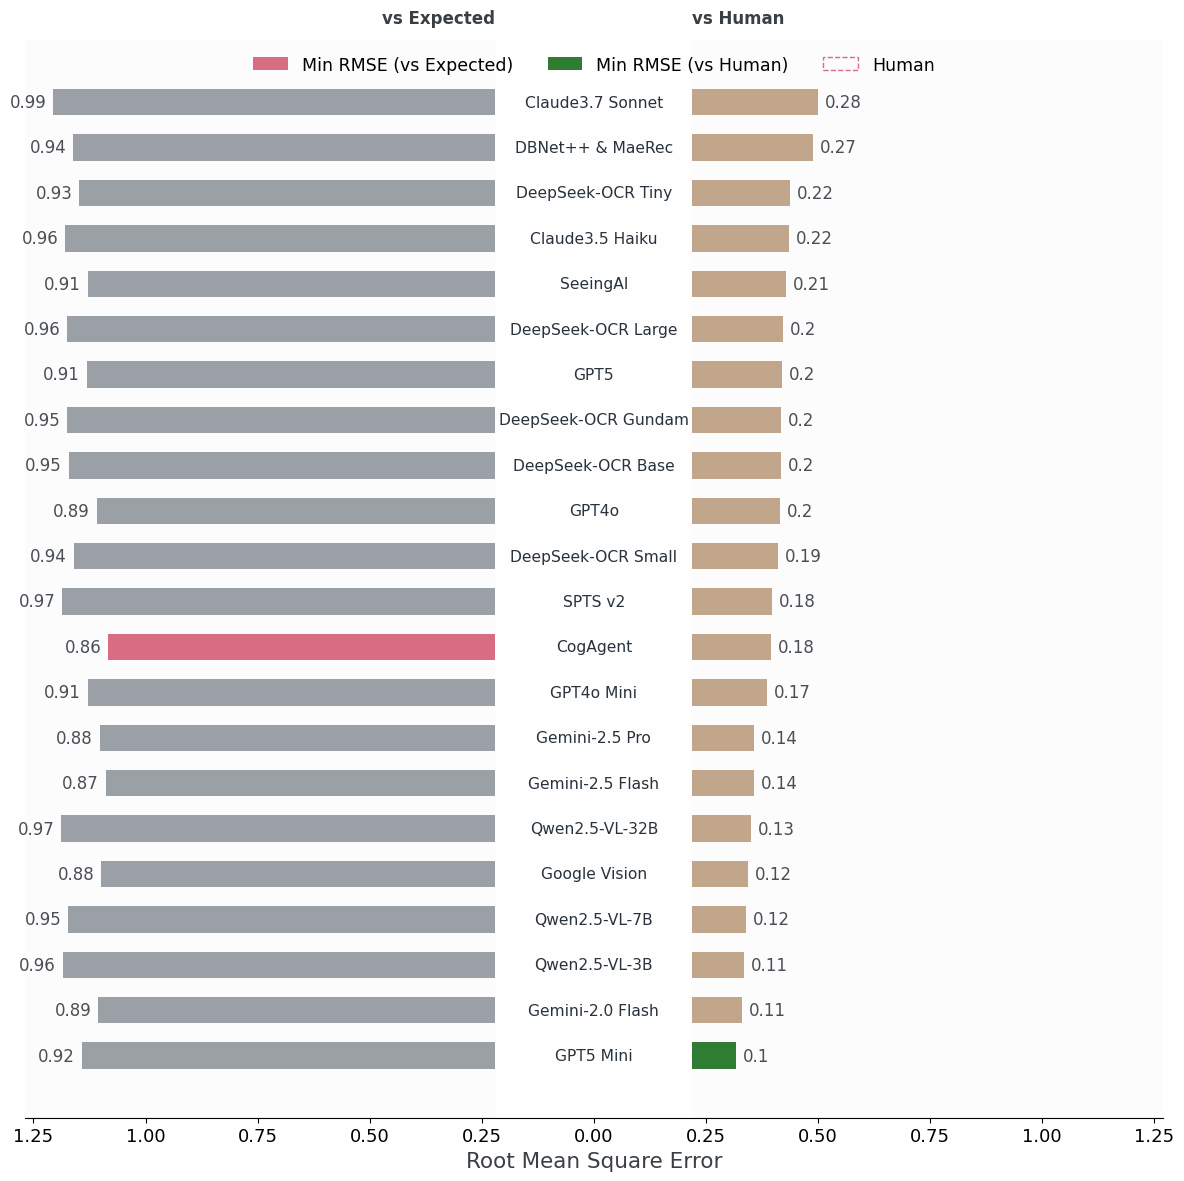

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def rmse(arr):
    return np.sqrt(np.mean(arr ** 2))

# --- metrics ---
rmse_vs_exp = final_df_fig[models].sub(final_df_fig['Expected'], axis=0).apply(rmse, axis=0)
models_wo_human = [m for m in models if str(m).casefold() != 'human']
rmse_to_human = final_df_fig[models_wo_human].sub(final_df_fig['Human'], axis=0).apply(rmse, axis=0)

# --- order & align (ascending by left) ---
order = rmse_to_human.sort_values(ascending=True).index.tolist()
left_vals  = rmse_vs_exp.reindex(order).values
right_vals = rmse_to_human.reindex(order).values

y = np.arange(len(order))
bar_h = 0.58

# --- colors & highlights ---
min_left_label  = order[np.nanargmin(left_vals)]
min_right_label = rmse_to_human.idxmin() if len(rmse_to_human) else None
left_colors  = ['#D76C82' if lab == min_left_label else '#9AA0A6' for lab in order]
right_colors = []
for lab, v in zip(order, right_vals):
    if np.isnan(v) or str(lab).casefold() == 'human':
        right_colors.append('none')
    elif lab == min_right_label:
        right_colors.append('#2E7D32')
    else:
        right_colors.append('#C2A68C')

# --- axis range & central gap ---
lim_left  = float(np.nanmax(left_vals))
lim_right = float(np.nanmax(right_vals[~np.isnan(right_vals)]) if np.any(~np.isnan(right_vals)) else 0.0)
lim = max(lim_left, lim_right, 1.0)
step = 0.25
max_tick = np.ceil(lim / step) * step

gap = max_tick * 0.22   # 中缝宽度的一半（可调：0.12~0.25）
left_anchor  = -gap      # 左柱起点在 -gap 处向左延伸
right_anchor =  gap      # 右柱起点在 +gap 处向右延伸

fig_h = max(6, 0.45 * len(order) + 2)
fig, ax = plt.subplots(figsize=(12, fig_h))

# 背景/网格
ax.set_facecolor('#FCFCFD')
# ax.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.5)
for s in ['top', 'right', 'left']: ax.spines[s].set_visible(False)

# --- bars (外移) ---
# 左：从 -gap 向左画，width 用正值，left=-(gap+value)
left_bars = ax.barh(
    y, left_vals, height=bar_h, color=left_colors, edgecolor='none',
    left=-(gap + left_vals), zorder=3
)
# Human 左侧空心
for patch, lab in zip(left_bars, order):
    if str(lab).casefold() == 'human':
        patch.set_facecolor('none'); patch.set_edgecolor('#D76C82')
        patch.set_linestyle('--'); patch.set_linewidth(1.8)

# 右：从 +gap 向右画
right_bars = ax.barh(
    y, np.nan_to_num(right_vals, nan=0.0), height=bar_h,
    color=right_colors, edgecolor='none', left=right_anchor, zorder=3
)
# 隐藏 Human/NaN 右半
for patch, lab, v in zip(right_bars, order, right_vals):
    if np.isnan(v) or str(lab).casefold() == 'human':
        patch.set_visible(False)

# --- 中缝与标题 ---
ax.axvspan(-gap, gap, color='white', alpha=0.95, zorder=1)  # 中间留白带
ax.text(-gap, 1.012, 'vs Expected',            transform=ax.get_xaxis_transform(), ha='right', va='bottom',
        fontsize=12, fontweight='bold', color='#3A3F44')
ax.text( gap, 1.012, 'vs Human',   transform=ax.get_xaxis_transform(), ha='left',  va='bottom',
        fontsize=12, fontweight='bold', color='#3A3F44')

# --- model names 放在中缝里（不与柱子重合） ---
for yi, lab in zip(y, order):
    ax.text(0, yi, str(lab), ha='center', va='center', fontsize=11.2, color='#28323C', zorder=4)

# --- x 轴：对称范围 + 绝对值刻度 ---
xmax = max_tick + gap + max_tick*0.05
ax.set_xlim(-xmax, xmax)
ax.xaxis.set_major_locator(MultipleLocator(step))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xticklabels([t.get_text().lstrip('-') for t in ax.get_xticklabels()], fontsize=13)
ax.set_xlabel('Root Mean Square Error', fontsize=15.5, color='#3A3F44')

# 移除 ytick 文本（我们用中缝标签）
ax.set_yticks(y); ax.set_yticklabels([]); ax.tick_params(axis='y', length=0)

# --- 值标签（条末端） ---
pad = max_tick * 0.015
for v, b in zip(left_vals, left_bars):
    if v <= 0: continue
    x = -gap - v - pad
    ax.text(x, b.get_y()+b.get_height()/2, f'{v:.2f}'.rstrip('0').rstrip('.'),
            ha='right', va='center', fontsize=12, color='#4A4F55', zorder=4)
for v, b in zip(right_vals, right_bars):
    if np.isnan(v) or v <= 0: continue
    x =  gap + v + pad
    ax.text(x, b.get_y()+b.get_height()/2, f'{v:.2f}'.rstrip('0').rstrip('.'),
            ha='left', va='center', fontsize=12, color='#4A4F55', zorder=4)

# --- 图例 ---
legend_handles = [
    Patch(facecolor='#D76C82', edgecolor='none', label='Min RMSE (vs Expected)'),
    Patch(facecolor='#2E7D32', edgecolor='none', label='Min RMSE (vs Human)'),
    # Patch(facecolor='#9AA0A6', edgecolor='none', label='Others (left)'),
    # Patch(facecolor='#C2A68C', edgecolor='none', label='Others (right)'),
    Patch(facecolor='none', edgecolor='#D76C82', linestyle='--', label='Human'),
]
ax.legend(handles=legend_handles, frameon=False, fontsize=12.5, ncol=3, loc='upper center')

plt.tight_layout()
plt.savefig('../../figure/totaltext_rmse_stacked.pdf', dpi=300)
# plt.show()